# Статистический анализ данных / Python
## Задание 4

**Правила:**

* Дедлайн **8 декаюря 23:59**.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[MADE19] Фамилия Имя - задание 4"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов), которую можно сделать с помощью печати в файл через инструменты браузера.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него. 
* Разделяйте код вычислений и отрисовки графиков. Так будет удобнее вам и проверяющим.


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook


__________________
### Задача 1. (3 балла)

С помощью критерия хи-квадрат проверьте, действительно ли код `sps.poisson(mu=5).rvs(size=1000)` генерирует выборку размера 1000 из пуассоновского распределения с параметром 5. 

*Указания*
1. Не забудьте учесть условия применимости критерия хи-квадрат;
2. Для вычисления плотности воспользуйтесь `sps.poisson(mu=5).pmf`;
3. Для подсчета количества элементов в разбиении на множества воспользуйтесь `np.unique(sample, return_counts=True)`;
4. Не нужно писать сколь-либо универсальный код, который одним нажатием кнопки проверяет гипотезу с учетом всех условий применимости критерия. Расписывайте код поэтапно, на каждый логический этап свой код для *конкретной* реализации выборки. Так проще реализовать, и проще проверять.

In [2]:
n=1000

In [3]:
#генерим выборку
x = sps.poisson(mu=5).rvs(size=n)

#считаем частоты значений
unique_values, freq = np.unique(x, return_counts=True)

#оцениваем ожидаемые частоты
expected_freq = [sps.poisson(mu=5).pmf(k)*n for k in unique_values]

sample = pd.DataFrame()
sample['value'] = unique_values
sample['freq'] = freq
sample['expected_freq'] = expected_freq

In [4]:
sample

,value,freq,expected_freq
0,0,8,6.737947
1,1,44,33.689735
2,2,79,84.224337
3,3,136,140.373896
4,4,200,175.467370
5,5,178,175.467370
6,6,126,146.222808
7,7,90,104.444863
8,8,63,65.278039
9,9,43,36.265577


In [5]:
#Значения больше 10 объединямв один бакет
critical = 11

In [6]:
#статистика по объединённом бакету
new_expected_freq = sample.loc[sample['value']>=critical, 'expected_freq'].sum()
new_freq = sample.loc[sample['value']>=critical, 'freq'].sum()
new_value='{}+'.format(critical)

additional_sample = pd.DataFrame({'value': [new_value], 'freq':[new_freq], 'expected_freq':[new_expected_freq]})

#выкидываем из старого сэмпла исключаемые редкие значения
ok_sample = sample.loc[sample['value']<critical]

#добавляем новый баке в сэмлп
new_sample = ok_sample.append(additional_sample, ignore_index=True)

In [7]:
new_sample

,value,freq,expected_freq
0,0,8,6.737947
1,1,44,33.689735
2,2,79,84.224337
3,3,136,140.373896
4,4,200,175.467370
5,5,178,175.467370
6,6,126,146.222808
7,7,90,104.444863
8,8,63,65.278039
9,9,43,36.265577


In [8]:
#Подстраховка
if np.min(new_sample['expected_freq'])<5:
    raise BaseException('Не выполнен критерий применимости')

In [9]:
#проверка критерия хи-вадрат
sps.chisquare(new_sample['freq'], new_sample['expected_freq'])

Power_divergenceResult(statistic=15.508705055596348, pvalue=0.16037199940778676)

**Вывод:**

Значение p-value высокое, оснований отвергать нулевую гипотезу о принадлежности полученной выборки распределению Пуассона с параметром 5 нет

__________________
### Задача 2. (5 баллов)


Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a>, взяв все колонки, кроме `Class`.

In [10]:
columns_ = ['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 
           'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline' ]

data = pd.read_csv('data/wine.data', header=None, names = columns_).drop(['class'], axis=1)

In [11]:
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Для каждого параметра нарисуте Q-Q plot. Для наглядности и экономии места рисуйте графики в несколько столбцов, используя `plt.subplot`.

In [12]:
data.shape

(178, 13)

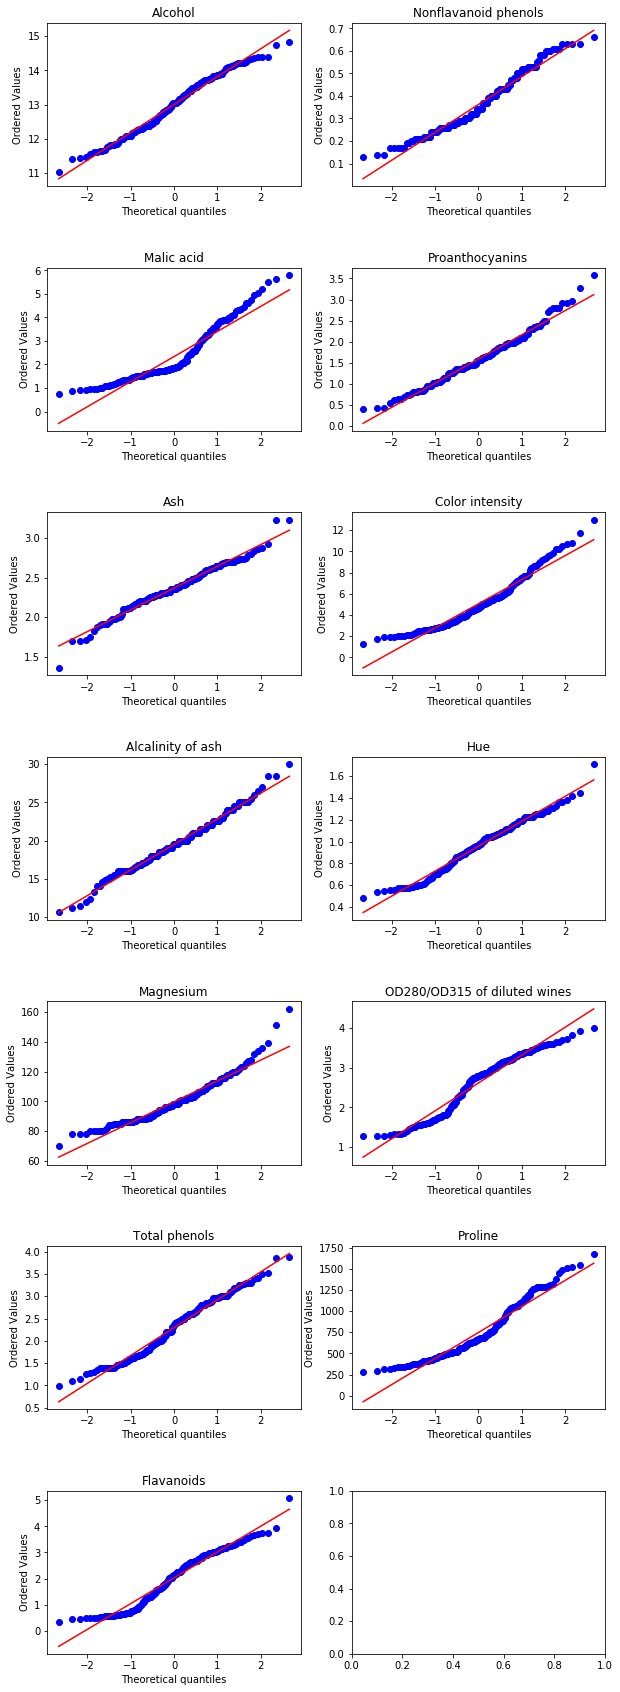

In [13]:
fig, axes = plt.subplots(7,2, figsize=[10,30], gridspec_kw={'wspace':0.2, 'hspace':0.5} )
for i in range(len(data.columns)):
    col = i//7
    row = i%7
    #print(row, col)
    sps.probplot(data[data.columns[i]], plot=axes[row, col])
    axes[row, col].set_title(data.columns[i])
    
plt.show()   

Для каких параметров можно говорить об их нормальности и почему?

**Ответ:** Судя по графикам Q-Q почти нормально распределены (эмпирические квантили совпадают с теоретическими) переменные Alcanity of ash, Hue, Ash, Total phenols, Proanthocyanins, Alcohol, Nonflavanoid phenols

Проверьте нормальность каждого параметра статистическими критериями. Прежде чем выполнить следующую часть задачи, ответьте на вопросы.

Для каждого параметра используйте несколько критериев проверки нормальности. Какие критерии вы будете использовать?

**Ответ:** Критерий Шапиро-Уилка, Критерий хи-квадрат, критерий Колмогорова-Смирнова

Результаты критериев нужно обработать с помощью *одной* процедуры множественной проверки гипотез для всех параметров и всех критериев сразу. Почему так нужно делать?

**Ответ:** различные критерии могут оценивать схожесть распределений по различным свойствам, поэтому нужно проверять по нескольким критериям и проводить множественную проверку гипотез

Какой метод для контроля FWER стоит применить и почему?

**Ответ:** Методы Бонферрони и Холма, т.к. они универсальны и не зависят от связей между статистиками. Так же попробую метод Шидака для интереса

Как понять из результата процедуры множественной проверки гипотез, нормальность каких параметров следует отклонить?

**Ответ:** Отклонить гипотезу о нормальности тех параметров, где хотя бы по одному критерию гипотеза была отклонена

Если нормальность не отклоняется, что можно сказать про выборку (ответ в презентации с лекции)? 

**Ответ:** Выборка согласуется с основной гипотезой

Реализуйте данную схему. Предварительно соберите p-value всех критериев в таблицу. 

Функция `multipletests` принимает только одномерные массивы, поэтому для полученной `numpy`-таблицы нужно воспользоваться методом `ravel`. Результат нужно собрать обратно в таблицу с помощью метода `reshape`, которому нужно передать размерности таблицы. Для наглядности сделайте таблицу с помощью `pandas.DataFrame`. В качестве названий строк используйте названия переменных, а названий столбцов --- используемые критерии.

In [14]:
def test_nomality(x):
    shapiro_stat = sps.shapiro(x)
    ks_stat = sps.kstest(x, sps.norm.cdf, args=(np.mean(x), np.std(x)))
    chi2_stat = sps.normaltest(x)
    return [shapiro_stat[1], ks_stat[1], chi2_stat[1]]

In [15]:
# расчёт критериев
p_values=list()
for c in data.columns:
    p_values.append([c]+test_nomality(data[c]))
    
#критерии в датафреймах
p_values_df = pd.DataFrame(columns = ['variable', 'Shapiro', 'KS', 'Chi2'], data=p_values)
p_values_df.head()

,variable,Shapiro,KS,Chi2
0,Alcohol,2.005172e-02,0.358903,3.416320e-04
1,Malic acid,2.945930e-10,0.000003,3.174217e-06
2,Ash,3.868526e-02,0.584057,3.631602e-02
3,Alcalinity of ash,2.638694e-01,0.460216,2.100427e-01
4,Magnesium,6.345416e-07,0.110088,4.658885e-09


In [16]:
def multiTest(p_values, method='bonferroni'):
    #вычисление скорректированных p-value
    corrected_p_values = np.apply_along_axis(lambda x: multipletests(x, method=method)[1], 
                                             axis=0, arr=p_values.values[:,1:])
    #вычисление решений по скорректированных p-value
    corrected_rejections = np.apply_along_axis(lambda x: multipletests(x, method=method)[0], 
                                               axis=0, arr=p_values.values[:,1:])
    #сохраняем скорректированные p-value в датафрейм
    corrected_p_values_df = pd.DataFrame(corrected_p_values, 
                                     columns=p_values_df.columns[1:].values+'_{}'.format(method))
    #сохраняем решения по скорректированным p-value в датафрейм
    corrected_rejections_df = pd.DataFrame(corrected_rejections, 
                                       columns=p_values_df.columns[1:].values+'_{}_reject'.format(method))
    #добавляем финальное решение - хотя бы один отказ - отказ
    corrected_rejections_df['{}_final_reject'.format(method)] = corrected_rejections_df.max(axis=1)
    
    #собираем в итоговый датафрейм скорректированные p-value и решения по ним
    multi_test_result = pd.concat([p_values_df, corrected_p_values_df, corrected_rejections_df], axis=1)
    
    
    return multi_test_result

In [17]:
bonferroni_multitest = multiTest(p_values_df)
bonferroni_multitest.head()

,variable,Shapiro,KS,Chi2,Shapiro_bonferroni,KS_bonferroni,Chi2_bonferroni,Shapiro_bonferroni_reject,KS_bonferroni_reject,Chi2_bonferroni_reject,bonferroni_final_reject
0,Alcohol,2.005172e-02,0.358903,3.416320e-04,0.260672,1,0.00444122,False,False,True,True
1,Malic acid,2.945930e-10,0.000003,3.174217e-06,3.82971e-09,4.34574e-05,4.12648e-05,True,True,True,True
2,Ash,3.868526e-02,0.584057,3.631602e-02,0.502908,1,0.472108,False,False,False,False
3,Alcalinity of ash,2.638694e-01,0.460216,2.100427e-01,1,1,1,False,False,False,False
4,Magnesium,6.345416e-07,0.110088,4.658885e-09,8.24904e-06,1,6.05655e-08,True,False,True,True


In [18]:
holm_multitest = multiTest(p_values_df, 'holm')
holm_multitest.head()

,variable,Shapiro,KS,Chi2,Shapiro_holm,KS_holm,Chi2_holm,Shapiro_holm_reject,KS_holm_reject,Chi2_holm_reject,holm_final_reject
0,Alcohol,2.005172e-02,0.358903,3.416320e-04,0.0722669,1,0.00273306,False,False,True,True
1,Malic acid,2.945930e-10,0.000003,3.174217e-06,3.82971e-09,4.34574e-05,3.49164e-05,True,True,True,True
2,Ash,3.868526e-02,0.584057,3.631602e-02,0.0773705,1,0.108948,False,False,False,False
3,Alcalinity of ash,2.638694e-01,0.460216,2.100427e-01,0.263869,1,0.420085,False,False,False,False
4,Magnesium,6.345416e-07,0.110088,4.658885e-09,6.97996e-06,0.933052,5.59066e-08,True,False,True,True


In [19]:
# нормальные по бонферони
bonferroni_multitest.loc[bonferroni_multitest['bonferroni_final_reject']==False, 'variable']

2                   Ash
3     Alcalinity of ash
8       Proanthocyanins
10                  Hue
Name: variable, dtype: object

In [20]:
# нормальные по холму
holm_multitest.loc[holm_multitest['holm_final_reject']==False, 'variable']

2                   Ash
3     Alcalinity of ash
10                  Hue
Name: variable, dtype: object

Для каких параметров нормальность не отвергается?

**Ответ:** Ash, Alcanity of Ash, Hue